In [1]:
import os
import time
import random
import collections
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from kaggle_environments import evaluate, make, utils
from kaggle_environments import agent as kaggle_env_agent
from tqdm.notebook import tqdm
from IPython.display import clear_output
from datetime import datetime
from enum import Enum


is_kaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", None) is not None
if is_kaggle:
    # https://www.kaggle.com/product-feedback/231543
    !pip install ipympl
    %matplotlib inline
else:
    %matplotlib notebook

    
# use in order to train an existing model. if not found, trainer will default to creating new
PRE_TRAINED_MODEL_PATH = "model_state_dict.pth"


TRAINING_EPISODES = 70_000
TRAINING_CHECKPOINT_INTERVAL = 1000
TRAINING_CHECKPOINT_FOLDER = "./"

INVALID_MOVE_VALUE = float("-inf")

ROWS = 6
COLUMNS = 7
IN_A_ROW = 4


env = make(
  "connectx",
  configuration={"rows": ROWS, "columns": COLUMNS, "inarow": IN_A_ROW},
  debug=True,
)
env.render()



In [2]:
def get_device():
    """
    determine device to run on
    NOTE: currently there's no sufficent MacOS M1 support. sticking to cpu in that case
    :return: the device
    """
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return "cpu"
        # return "mps"
    elif torch.cuda.is_available():
        return "cuda"
    return "cpu"

device = get_device()
device

'cuda'

In [3]:
class Utils:
    """
    collection of generic connect-x utils
    """
    @staticmethod
    def select_random_valid_index(tensor):
        """
        select a random idx which satisfies: tensor[random idx] is a valid move
        """
        while True:
            random_idx = random.randint(0, tensor.shape[1] - 1)
            if tensor[0, random_idx] != INVALID_MOVE_VALUE:
                return random_idx
         
    @staticmethod
    def get_other_player(player):
        if player == 1:
            return 2
        return 1
        
    @staticmethod
    def is_player_1(player):
        """
        check if an agent is player 1, using an observation object
        :param int player: player index
        """
        return player == 1

    @staticmethod
    def is_valid_action(action, board):
        """
        determine if action is valid
        :param int action: action to perform
        :param List board: board to perform on
        :return
        """
        return board[action] == 0

    @staticmethod
    def add_to_board(board, column, player):
        """
        add player's mark to the selected column in the board
        taken and tweaked from the connect-x challenge source code
        :param List board: connectx board
        :param int column: column to place on
        :param int player: player's mark
        :return: a copy of the board with the placed mark
        """
        board = board[:]
        rows = ROWS
        row = max([r for r in range(rows) if board[column + (r * COLUMNS)] == 0])
        board[column + (row * COLUMNS)] = player
        return board
    
    @staticmethod
    def is_board_full(board):
        """
        check if board is full
        :param List board: connectx board
        :return: True/False
        """
        return all([i != 0 for i in board[0: COLUMNS]])

    @staticmethod
    def set_invalid_move_values(board, moves_values):
        """
        change invalid moves' values to INVALID MOVE VALUE
        NOTE: changes original tensor
        """
        for i in range(moves_values.size(dim=1)):
            # check if last row is filled, if so, set to an indicator value indicating move isn't allowed
            if board[i] != 0:
                moves_values[0, i] = INVALID_MOVE_VALUE
        return moves_values
    
    @staticmethod
    def mean_reward(rewards):
        return sum(r[0] for r in rewards) / float(len(rewards))

    @staticmethod
    def is_win(board, column, mark, has_played=True):
        """
        check if there's a win on a column
        taken and tweaked from the connect-x challenge source code
        """
        columns = COLUMNS
        rows = ROWS
        inarow = IN_A_ROW - 1
        row = (
            min([r for r in range(rows) if board[column + (r * columns)] == mark])
            if has_played
            else max([r for r in range(rows) if board[column + (r * columns)] == 0])
        )

        def count(offset_row, offset_column):
            for i in range(1, inarow + 1):
                r = row + offset_row * i
                c = column + offset_column * i
                if (
                    r < 0
                    or r >= rows
                    or c < 0
                    or c >= columns
                    or board[c + (r * columns)] != mark
                ):
                    return i - 1
            return inarow

        return (
            count(1, 0) >= inarow  # vertical.
            or (count(0, 1) + count(0, -1)) >= inarow  # horizontal.
            or (count(-1, -1) + count(1, 1)) >= inarow  # top left diagonal.
            or (count(-1, 1) + count(1, -1)) >= inarow  # top right diagonal.
        )    
    
    @staticmethod
    def generate_random_board_positions(length):
        """
        generate a list of random board positions using random VS random game
        return: [{board: board, player: player}, ...]
        """
        random_agent = lambda obs, config: random.choice([c for c in range(config.columns) if obs["board"][c] == 0])
        board_positions = []
        for i in range(length):
            game_positions = []
            if i % 2 == 0:
                trainer = env.train(["random", None])
            else:
                trainer = env.train([None, "random"])

            observation = trainer.reset()

            while not env.done:
                game_positions.append({"board": observation["board"], "player": observation["mark"]}) 
                action = random_agent(observation, env.configuration)
                observation, _, _, _ = trainer.step(action)

            board_positions.append(random.choice(game_positions))                                          
        return board_positions


In [4]:
class Statistics:
    """
    performance statistics & metrics of a model
    """
    MEAN_REWARDS_VS_RANDOM_EPISODE_NUM = 5
    POSITIONS = [
                    # attacking moves required
                    {
                        "player": 1, "correct_action": 3,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 2,
                                  2, 2, 2, 0, 1, 1, 1]
                    },
                    {
                        "player": 1, "correct_action": 6,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 1,
                                  0, 0, 0, 0, 0, 0, 1,
                                  2, 2, 1, 0, 2, 2, 1]
                    },
                    {
                        "player": 1, "correct_action": 0,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  1, 0, 0, 0, 0, 0, 0,
                                  1, 0, 0, 0, 0, 0, 0,
                                  1, 2, 2, 0, 1, 2, 2]
                    },
                    {
                        "player": 1, "correct_action": 1,
                        "board": [0, 0, 0, 0, 0, 0, 1,
                                  0, 0, 0, 0, 0, 0, 2,
                                  0, 0, 0, 0, 0, 0, 1,
                                  0, 0, 0, 0, 0, 0, 2,
                                  1, 0, 1, 1, 2, 0, 1,
                                  1, 2, 2, 2, 1, 2, 2]
                    },
                    {
                        "player": 1, "correct_action": 4,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 1, 2, 0, 0,
                                  0, 0, 1, 2, 1, 2, 2,
                                  2, 1, 2, 2, 1, 1, 1]
                    },
                    {
                        "player": 1, "correct_action": 4,
                        "board": [1, 2, 0, 0, 0, 0, 0,
                                  2, 1, 0, 0, 0, 0, 0,
                                  1, 2, 0, 0, 0, 0, 0,
                                  2, 1, 0, 1, 2, 0, 0,
                                  1, 2, 1, 2, 1, 2, 2,
                                  2, 1, 2, 2, 1, 1, 1]
                    },
                    {
                        "player": 2, "correct_action": 3,
                        "board": [2, 0, 0, 0, 0, 0, 0,
                                  1, 1, 0, 0, 0, 0, 0,
                                  1, 2, 0, 0, 0, 0, 0,
                                  2, 1, 2, 1, 2, 0, 1,
                                  1, 2, 1, 2, 1, 2, 2,
                                  2, 1, 2, 2, 1, 1, 1]
                    },
            
                    # defensive moves required
                    {
                        "player": 1, "correct_action": 3,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 1, 1,
                                  2, 2, 2, 0, 1, 2, 1]
                    },
                    {
                        "player": 1, "correct_action": 6,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 2,
                                  0, 0, 0, 0, 0, 0, 2,
                                  1, 1, 2, 0, 1, 1, 2]
                    },
                    {
                        "player": 2, "correct_action": 4,
                        "board": [2, 0, 0, 0, 0, 0, 0,
                                  1, 1, 0, 0, 0, 0, 0,
                                  1, 2, 0, 0, 0, 0, 0,
                                  2, 1, 0, 1, 2, 0, 0,
                                  1, 2, 1, 2, 1, 2, 2,
                                  2, 1, 2, 2, 1, 1, 1]
                    },
                    {
                        "player": 2, "correct_action": 1,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 1, 0, 0, 0, 0, 0,
                                  2, 1, 0, 0, 0, 0, 0,
                                  2, 1, 0, 0, 0, 0, 0]
                    },
                    {
                        "player": 2, "correct_action": 1,
                        "board": [0, 0, 0, 0, 0, 1, 2,
                                  0, 0, 0, 0, 0, 2, 1,
                                  0, 0, 0, 0, 0, 1, 2,
                                  0, 1, 0, 0, 0, 2, 1,
                                  2, 1, 0, 0, 0, 1, 2,
                                  2, 1, 0, 1, 2, 2, 1]
                    },
                    {
                        "player": 2, "correct_action": 6,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 1,
                                  2, 0, 0, 0, 0, 0, 1,
                                  2, 0, 0, 0, 0, 0, 1]
                    },
                    {
                        "player": 2, "correct_action": 0,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  1, 1, 0, 0, 0, 0, 0,
                                  2, 2, 1, 0, 0, 0, 0,
                                  2, 2, 1, 1, 0, 0, 0]
                    },
                    {
                        "player": 2, "correct_action": 1,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  2, 1, 0, 0, 0, 0, 0,
                                  2, 1, 0, 0, 0, 0, 0,
                                  1, 1, 0, 0, 0, 0, 0,
                                  2, 2, 1, 0, 0, 0, 0,
                                  2, 2, 1, 1, 0, 0, 0]
                    },
                    {
                        "player": 2, "correct_action": 5,
                        "board": [0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 0, 0,
                                  0, 0, 0, 0, 0, 1, 0,
                                  0, 0, 0, 0, 0, 1, 0,
                                  0, 0, 0, 0, 2, 1, 0,
                                  0, 0, 0, 1, 2, 2, 0]
                    },
    ]
    
    
    def __init__(self):
        self.epsilons = collections.deque()
        self.rewards = []
        self.episode_lengths = []
        self.selected_actions = [0] * COLUMNS
        self.recent_selected_actions = collections.deque(maxlen=100)
        self.selected_actions_labels = [i for i in range(COLUMNS)]
        self.mean_reward_agent_vs_random = 0        
        self.mean_reward_random_vs_agent = 0
        self.mean_rewards_vs_random_labels = ["model vs rnd", "rnd vs model"]
        self.mean_max_predicted_value = []
        self.mean_max_predicted_value_episodes = []
        
        self.current_actions_from_positions = []
        self.current_actions_from_positions_episodes = []
    
        self.random_board_positions = Utils.generate_random_board_positions(8)
        
        self.fig, axes = plt.subplots(4, 2, figsize=(10.,10.))
        self.axis_epsilon, self.axis_avg_reward, self.axis_selected_action, self.axis_recent_selected_actions, self.axis_episode_lengths, self.axis_mean_rewards_vs_random, self.axis_mean_max_pred_value, self.axis_actions_from_pos = axes.flat
        self.fig.tight_layout(pad=3)
    
    def display_epsilons(self):
        """
        metric described in the original Deepmind's Atari DQN paper
        should increase as time passes
        """
        self.axis_epsilon.cla()
        self.axis_epsilon.plot(self.mean_max_predicted_value_episodes, self.mean_max_predicted_value)
        self.axis_epsilon.set(xlabel="Episode", ylabel="Mean of Max Q Values")
        
    def display_average_reward(self):
        """
        should be high as epsilon gets smaller
        """
        window = 100
        if len(self.rewards) < window:
            return
        
        df = pd.DataFrame(self.rewards)
        self.axis_avg_reward.cla()
        self.axis_avg_reward.plot(df.rolling(window=window).mean())
        self.axis_avg_reward.set(xlabel="Episode", ylabel=f"Avg Reward ({window} eps)")
        
    def display_selected_actions(self):
        self.axis_selected_action.cla()
        self.axis_selected_action.bar(self.selected_actions_labels, self.selected_actions)
        self.axis_selected_action.set(xlabel="Action", ylabel="# Selected")

    def display_recent_selected_actions(self):
        """
        dominant actions may indicate overfitting (using a naive strategy to win the given opponents)
        """
        self.axis_recent_selected_actions.cla()
        self.axis_recent_selected_actions.hist(list(self.recent_selected_actions))
        self.axis_recent_selected_actions.set(xlabel="Action", ylabel="# in last 100 selections")
        
    def display_episode_lengths(self):
        """
        episodes should probably get longer as time passes, due to better agents on both sides
        """
        self.axis_episode_lengths.cla()        
        self.axis_episode_lengths.hist(self.episode_lengths, bins=50)
        self.axis_episode_lengths.set(xlabel="Episode Length", ylabel="# episodes")
        self.axis_episode_lengths.set_xticks(np.arange(0, COLUMNS * ROWS, 5))
    
    def display_mean_rewards_vs_random(self):
        self.axis_mean_rewards_vs_random.cla()
        self.axis_mean_rewards_vs_random.bar(self.mean_rewards_vs_random_labels, [self.mean_reward_agent_vs_random, self.mean_reward_random_vs_agent], color="#5B2C6F")
        self.axis_mean_rewards_vs_random.set(ylabel=f"Mean Reward ({self.MEAN_REWARDS_VS_RANDOM_EPISODE_NUM} eps)")
    
    def display_mean_maximum_prediction_value(self):
        self.axis_mean_max_pred_value.cla()
        self.axis_mean_max_pred_value.plot(self.epsilons)
        self.axis_mean_max_pred_value.set(xlabel="Episode", ylabel="Epsilon")

    def display_actions_from_position(self):
        """
        make sure model makes the correct moves in simple positions
        """
        self.axis_actions_from_pos.cla()
        self.axis_actions_from_pos.plot(self.current_actions_from_positions_episodes, self.current_actions_from_positions)
        self.axis_actions_from_pos.set(xlabel="Episode", ylabel=f"correct actions (out of {len(self.POSITIONS)})")
        
    def display_all(self):
        self.display_epsilons()
        self.display_average_reward()
        self.display_selected_actions()
        self.display_episode_lengths()
        self.display_recent_selected_actions()
        self.display_mean_rewards_vs_random()
        self.display_mean_maximum_prediction_value()
        self.display_actions_from_position()
        self.fig.canvas.draw()
        
    def save_all(self, filename):
        self.fig.savefig(filename)
    
    def add_epsilon(self, epsilon):
        self.epsilons.append(epsilon)
        
    def add_reward(self, reward):
        self.rewards.append(reward)
    
    def add_episode_length(self, length):
        self.episode_lengths.append(length)
    
    def add_selected_action(self, action):
        self.selected_actions[action] += 1
        self.recent_selected_actions.append(action)
    
    @torch.no_grad()
    def add_mean_reward_model_vs_random(self, model):
        agent = Agent(model)
        evaluate("connectx", [agent.agent, "random"], num_episodes=self.MEAN_REWARDS_VS_RANDOM_EPISODE_NUM)
        self.mean_reward_agent_vs_random = Utils.mean_reward(evaluate("connectx", [agent.agent, "random"], num_episodes=self.MEAN_REWARDS_VS_RANDOM_EPISODE_NUM))
        
    @torch.no_grad()
    def add_mean_reward_random_vs_model(self, model):
        agent = Agent(model)
        self.mean_reward_random_vs_agent = Utils.mean_reward(evaluate("connectx", ["random", agent.agent], num_episodes=self.MEAN_REWARDS_VS_RANDOM_EPISODE_NUM))
            
    @torch.no_grad()
    def add_mean_maximum_prediction_value(self, model, current_episode):
        outputs = []
        for position in self.random_board_positions:
            max_output = model.query_using_board(position["board"], position["player"], replace_invalid=True).max().item()
            outputs.append(max_output)
        self.mean_max_predicted_value.append(sum(outputs) / len(outputs))
        self.mean_max_predicted_value_episodes.append(current_episode)
    
    @torch.no_grad()
    def add_mean_maximum_prediction_value(self, model, current_episode):
        outputs = []
        for position in self.random_board_positions:
            max_output = model.query_using_board(position["board"], position["player"], replace_invalid=True).max().item()
            outputs.append(max_output)
        self.mean_max_predicted_value.append(sum(outputs) / len(outputs))
        self.mean_max_predicted_value_episodes.append(current_episode)
        
    @torch.no_grad()
    def add_actions_from_position(self, model, episode):
        self.current_actions_from_positions.append(0)
        self.current_actions_from_positions_episodes.append(episode)
        for pos in self.POSITIONS:
            action = model.query_using_board(pos["board"], pos["player"], replace_invalid=True).argmax().item()
            if action == pos["correct_action"]:
                self.current_actions_from_positions[-1] += 1
        
    

In [5]:
class ConnectXModel(nn.Module):
    def __init__(self):
        """
        model expects ROWS x COLUMNS image (1-channel)
        """
        super(ConnectXModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4)   
        self.conv2 = nn.Conv2d(16, 512, kernel_size=3) 
        # resulting rows x cols x out_channel where: rows (resp. cols) = ROWS (resp. COLUMNS) - k1 + 1 - k2 + 1, filters = 16x32
        self.fc1 = nn.Linear((ROWS - 5) * (COLUMNS - 5) * 512, 256)
        self.fc2 = nn.Linear(256, COLUMNS)        
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.flatten()
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.reshape(1, -1) # for compatability
    
    @staticmethod
    def board_to_model_input(board, player):
        """
        preprocess the board and represent it better:
        * change opponents pieces to -1, and own pieces to 1
        * reshape to fit model input
        
        :param List board: connectx board
        :param int player: own player's mark
        """
        model_input = torch.tensor(board, dtype=torch.float32, device=device).reshape(1, 1, ROWS, COLUMNS)
        if Utils.is_player_1(player):
            model_input[model_input == 2] = -1 # opponent's pieces to -1 (agent is already represented as 1)
            
        else: # flip representation of pieces
            model_input[model_input == 1] = -1 # opponent's pieces to -1
            model_input[model_input == 2] = 1  # agent's pieces to 1
            
        return model_input

    def query_using_board(self, board, player, replace_invalid=True):
        """
        query the model using a connect-x board
        
        :param List board: connect-x env board
        :param int player: player's mark (1 or 2)
        :param bool replace_invalid: whether or not to replace invalid (illegal) moves with a placeholder value
                                     NOTE: using replace_invalid=True affects autograd
        :return: torch.tensor with the model's results
        """
        model_input = self.board_to_model_input(board, player)
        moves_values = self(model_input)
        if replace_invalid:
            moves_values = Utils.set_invalid_move_values(board, moves_values)
        return moves_values
    



In [6]:
 class Agent:
    def __init__(self, model, tree_search_class=None, search_depth=4):
        """
        model: model to query for moves
        tree_search_class: class which performs search (e.g., MiniMax class). provide None to fallback to model query
        search_depth: search depth for tree search algorithms
        """
        self.model = model
        self.tree_searcher = None
        if tree_search_class is not None:
            self.tree_searcher = tree_search_class(self.model.query_using_board, search_depth)

    def query_model(self, observation, replace_invalid=True):
        """
        query the agent's model directly using an observation
        
        :param observation: connectx env observation
        :param bool replace_invalid: whether or not to replace invalid (illegal) moves with a placeholder value
        :return: the result of the query
        """
        return self.model.query_using_board(observation["board"], observation["mark"], replace_invalid=replace_invalid)
    
    def query_searcher(self, observation):
        """
        determine the best action and its score using the tree searcher & model
        :param observation: connectx env observation
        :return: (best_action, action_score) pair
        """
        return self.tree_searcher.search(observation)
        
    def agent(self, observation, configuration):
        """
        an agent, in connect-x competition format
        query using the tree searcher if exists, else, fallback to the model
        :param observation: connect-x env observation (includes the board state, player, etc.)
        :param configuration: connect-x env configuration
        """
        with torch.no_grad():
            if self.tree_searcher is not None:
                return self.query_searcher(observation)[0]
            return self.query_model(observation).argmax().item()



In [7]:
class DQNTrainer:
    """
    train a model using:
    * DQN: inspired by https://www.deepmind.com/publications/playing-atari-with-deep-reinforcement-learning
    * self play: inspired by AlphaZero
    * Prioritized Sweeping: a simple version. learn more from last episode moves (winning/losing moves)
    """
    PREV_MODELS_CAPACITY = 50
    REPLAY_MEMORY_CAPACITY = 5000
    REPLAY_MEMORY_SAMPLE_SIZE = 32
    REPLAY_MEMORY_MIN_SIZE_FOR_LEARNING = 500
    
    def __init__(self, model, loss_func=nn.MSELoss, learning_rate=0.1, gamma=0.7, epsilon_max=1, epsilon_min=0.1, epsilon_dec_rate=0.99998):
        model.train()
        self.model = model
        self.replay_memory = collections.deque(maxlen=self.REPLAY_MEMORY_CAPACITY)
        self.replay_memory_prioritized = collections.deque(maxlen=self.REPLAY_MEMORY_CAPACITY)        
        self.prev_models = collections.deque(maxlen=self.PREV_MODELS_CAPACITY)
        self.loss_func = loss_func()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_dec_rate = epsilon_dec_rate
        self.frozen_model = None
        
        # stats related
        self.episode_rewards = 0
        self.stats = Statistics()
        
        
    def _select_move(self, observation):
        """
        select an action using a greedy-epsilon algorithm
        """
        moves_values = self.model.query_using_board(observation["board"], observation["mark"]) 
        if random.uniform(0, 1) > self.epsilon: # exploit - use best move
            return torch.argmax(moves_values).item()
        # explore - use a random move
        return Utils.select_random_valid_index(moves_values)
    
    @staticmethod
    def _create_trainer(opponent_agent, is_player_1):
        if is_player_1:
            return env.train([None, opponent_agent])
        return env.train([opponent_agent, None])
 
    @staticmethod
    def alter_reward(reward, done):
        """
        can be used to alter the reward - for example, to penalize longer games (if not done: return -1 / (ROWS * COLUMNS))
        """
        return reward
        
    def _move_and_save(self, trainer, observation, move):
        """
        make a move and save it to replay memory (for later learning)
        return the new observation, after the move was made
        """
        new_observation, reward, done, info = trainer.step(move)
        reward = self.alter_reward(reward, done)
        seq = (observation, move, reward, new_observation, done,)
        self.replay_memory.append(seq)
        if done:
            # last move, therefore important. add to the prioritzed replay_memory
            self.replay_memory_prioritized.append(seq)
        
        self.episode_rewards += reward
        self.stats.add_selected_action(move)
        return new_observation
    
    def _learn(self):
        """
        train the model using the replay memory
        """
        if len(self.replay_memory) < self.REPLAY_MEMORY_MIN_SIZE_FOR_LEARNING:
            # wait for enough data to accumulate
            return
        
        # 2/3 of learning goes to random samples, 1/3 goes to the prioritized actions
        sampled_memory = random.sample(self.replay_memory, self.REPLAY_MEMORY_SAMPLE_SIZE * 2 // 3) + random.sample(self.replay_memory_prioritized, self.REPLAY_MEMORY_SAMPLE_SIZE // 3)
        random.shuffle(sampled_memory)

        for observation, action, reward, next_observation, done in sampled_memory:
            pred = self.model.query_using_board(observation["board"], observation["mark"], replace_invalid=False) 
            target = pred.detach().clone()
            q_new = reward
            if not done:
                q_new = reward + self.gamma * (self.frozen_model.query_using_board(next_observation["board"], next_observation["mark"], replace_invalid=True).max().item())
            target[0, action] = q_new            
            self.optimizer.zero_grad()
            loss = self.loss_func(pred, target)
            loss.backward()        # calculate gradient
            self.optimizer.step()  # perform descent
    
    def _create_opponent_agent(self):
        """
        randomize an opponent using previous versions of the model
        """
        model = random.choice(self.prev_models)
        return Agent(model).agent
        
    
    def train(self, episodes, checkpoint_interval=None, checkpoint_folder=None):
        """
        main loop
        :param int episodes: number of episodes to train against
        :param int checkpoint_interval: interval to save a checkpoint by. e.g., per 1000 episodes
        :param string checkpoint_folder: folder to store the checkpoints in
        :return: (trained_model, model_training_statistics) tuple
        """
        if checkpoint_interval is not None and checkpoint_folder is None:
            raise Exception("Must specify a checkpoint folder")
        
        self.model.train()
        self.frozen_model = copy.deepcopy(self.model)  # increases learning stability

        progress_bar = tqdm(range(episodes))
        for episode in progress_bar:
            if checkpoint_interval is not None and episode > 0 and episode % checkpoint_interval == 0:
                # save checkpoint
                now = datetime.now().strftime("%Y%d%m_%H%M")
                torch.save(self.model.state_dict(), f"{checkpoint_folder}/checkpoint__{episode}__{now}.pth")
                self.stats.save_all(f"{checkpoint_folder}/checkpoint__{episode}__{now}.png")
            
            # decrease epsilon
            self.epsilon = max(self.epsilon * self.epsilon_dec_rate, self.epsilon_min)
            
            if episode % 100 == 0:
                # store statistics
                self.stats.add_mean_reward_model_vs_random(self.model)
                self.stats.add_mean_reward_random_vs_model(self.model)
                self.stats.add_mean_maximum_prediction_value(self.model, episode)
                self.stats.add_actions_from_position(self.model, episode)
                self.stats.display_all()
            
            if episode % 500 == 0:
                self.prev_models.append(copy.deepcopy(self.model))  # store model as a previous model to play against
                self.frozen_model = copy.deepcopy(self.model)       # store model as a frozen agent for learning stability
            
            # my pc just can't handle it
            # if episode > 0 and episode % 1000 == 0 and not is_kaggle: 
            #     print("resting.")
            #     time.sleep(40)
            #     print("waking up.")
            
            opponent_agent = self._create_opponent_agent()                    # switch opponent
            trainer = self._create_trainer(opponent_agent, episode % 2 == 0)  # switch playing side
            observation = trainer.reset()                                     # create a new game
            
            while not env.done:
                move = self._select_move(observation)
                observation = self._move_and_save(trainer, observation, move)
                self._learn()
            
            # update statistics
            self.stats.add_epsilon(self.epsilon)
            self.stats.add_episode_length(observation["step"])
            self.stats.add_reward(self.episode_rewards)
            self.episode_rewards = 0
        
        
        if checkpoint_interval is not None:
            # store last checkpoint
            now = datetime.now().strftime("%Y%d%m_%H%M")
            torch.save(self.model.state_dict(), f"{checkpoint_folder}/checkpoint_final__{now}.pth")
            self.stats.save_all(f"{checkpoint_folder}/checkpoint_final__{now}.png")
            
        return self.model, self.stats

        
        

In [8]:
class AlphaBeta:
    """
    AlphaBeta pruning, using a generic evaluation function
    """
    class States(Enum):
        WIN = 100_000
        LOSE = -100_000
        DRAW = 0
        INVALID_MOVE = float('-inf')
    
    def __init__(self, eval_func, search_depth):
        """
        :param eval_func: function to evaulate the position by, when reaching max depth
        :param int search_depth: max depth to search by
        """
        self.eval_func = eval_func
        self.search_depth = search_depth
    
    def search(self, observation):
        """
        perform the search
        :param observation: connect-x observation (includes board position, player, etc.)
        :return: (best_action, action_score) tuple
        """
        return self._search(observation["board"], observation["mark"], self.search_depth, self.States.LOSE.value, self.States.LOSE.value)
    
    def _search(self, board, player, depth, our_best_score, opponent_best_score):
        """
        recursive implementaion for AlphaBeta pruning
        :param List board: connect-x board
        :param int player: own player's mark
        :param int/float our_best_score: best score found in the search tree so far
        :param int/float opponent_best_score: best score found for the opponent so far
        :return: (best_action, action_score) tuple
        """
        search_results = []
        board = board[:]

        for column in range(COLUMNS): # check if there's a winning move
            if Utils.is_valid_action(column, board) and Utils.is_win(board, column, player, False):
                return column, self.States.WIN.value
        
        if Utils.is_board_full(board):
            return None, self.States.DRAW.value
        
        if depth == 0: # depth limit exceeded, estimate using evaluation function
            actions_values = self.eval_func(board, player)
            best_move = actions_values.argmax().item()
            score = actions_values[0, best_move].item()
            return best_move, score
            
        for column in range(COLUMNS):            
            if Utils.is_valid_action(column, board):
                result = self._search(Utils.add_to_board(board, column, player), Utils.get_other_player(player), depth - 1, opponent_best_score, our_best_score)
                if result[1] == self.States.LOSE.value: # can finish early, as we win using this move
                    return column, self.States.WIN.value
                
                current_move_score = result[1] * -1
                
                if result[1] < opponent_best_score: # not the optimal path for opponent, it won't choose it anyway
                    return None, current_move_score
                
                search_results.append(current_move_score)
                our_best_score = max(our_best_score, current_move_score)
                    
            else:
                search_results.append(self.States.INVALID_MOVE.value) # invalid move is a win for the opponent
        best_move = int(np.argmax(search_results))
        score = search_results[best_move]
        return best_move, score
    
    


Could not load weights! skipping.



  0%|          | 0/70000 [00:00<?, ?it/s]

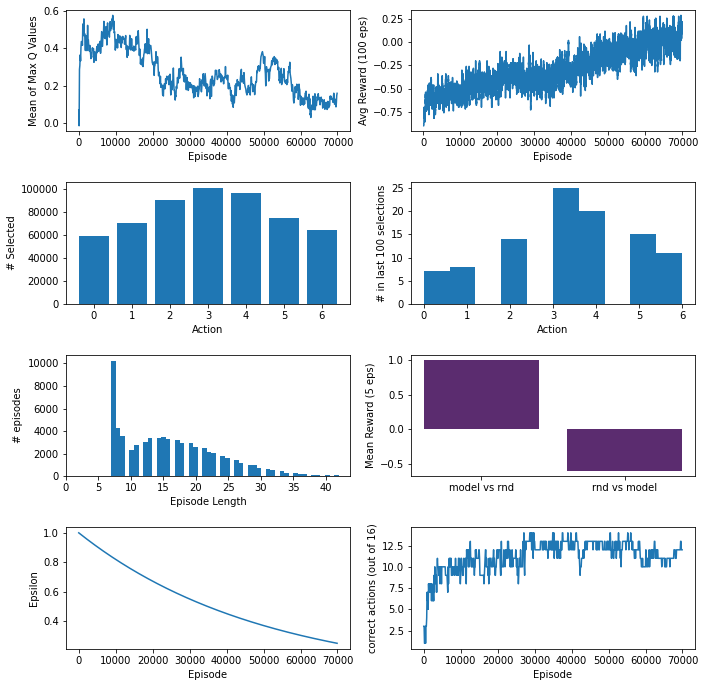

In [9]:
# init and train the network

net = ConnectXModel()
net.to(device)

try:
    net.load_state_dict(torch.load(PRE_TRAINED_MODEL_PATH, map_location=device))
    print("Loaded previous weights successfully.\n")
except Exception as e:
    print("Could not load weights! skipping.\n")

trainer = DQNTrainer(net)
net, stats = trainer.train(TRAINING_EPISODES, TRAINING_CHECKPOINT_INTERVAL, TRAINING_CHECKPOINT_FOLDER)


In [10]:
no_alphabeta = Agent(net, None)
with_alphabeta = Agent(net, AlphaBeta, 4)

num_episodes = 15

print("no alpha-beta:")
print(f"agent vs negamax: ", Utils.mean_reward(evaluate("connectx", [no_alphabeta.agent, "negamax"], num_episodes=num_episodes)))
print(f"negamax vs agent: ", Utils.mean_reward(evaluate("connectx", ["negamax", no_alphabeta.agent], num_episodes=num_episodes)))

print("\nwith alpha-beta:")
print(f"agent vs negamax: ", Utils.mean_reward(evaluate("connectx", [with_alphabeta.agent, "negamax"], num_episodes=num_episodes)))
print(f"negamax vs agent: ", Utils.mean_reward(evaluate("connectx", ["negamax", with_alphabeta.agent], num_episodes=num_episodes)))



no alpha-beta:
agent vs negamax:  -0.6
negamax vs agent:  0.6

with alpha-beta:
agent vs negamax:  0.4666666666666667
negamax vs agent:  -1.0


# Manually Experimenting with the Results

In [11]:
%%script false --no-raise-error


# Compare model versions

def agent_from_path(path, tree_search_class=None, search_depth=4):
    model = ConnectXModel()
    model.load_state_dict(torch.load(path, map_location=device))
    return Agent(model, tree_search_class, search_depth)

paths = [
    "checkpoint_final__20221910_1937.pth",
    "checkpoint__70000__20221910_1852.pth",
    "checkpoint__60000__20221910_1744.pth",
    "checkpoint__50000__20221910_1644.pth",
    "checkpoint__40000__20221910_1541.pth",
    "checkpoint__30000__20221910_1447.pth",
    "checkpoint__20000__20221910_1351.pth",
    "checkpoint__10000__20221910_1310.pth",
    "checkpoint__1000__20221910_1237.pth",
]

agents = [agent_from_path(path) for path in paths]
agents_alphabeta = [agent_from_path(path, AlphaBeta, 3) for path in paths]


In [12]:
%%script false --no-raise-error


def compete(agents, num_episodes):
    """
    compete all vs all. print scores and winners
    """
    pairs = [(i, j) for i in range(len(agents)) for j in range(len(agents)) if i != j]
    scores = [0] * len(agents)

    for i, j in pairs:
        avg_reward = Utils.mean_reward(evaluate("connectx", [agents[i].agent, agents[j].agent], num_episodes=num_episodes))
        scores[i] += avg_reward
        scores[j] -= avg_reward
        print(f"agent {i} vs agent {j}: ", avg_reward)
        
    print("\n### score per agent: ###")
    print(scores)
    print(f"\nwinner: agent {np.array(scores).argmax()}")
    

def vs_negamax(agents, num_episodes=5):
    """
    let agents play against the builtin negamax agent. decide who wins
    """
    scores = []
    for i, agent in enumerate(agents):
        score_1 = Utils.mean_reward(evaluate("connectx", [agent.agent, "negamax"], num_episodes=num_episodes))
        score_2 = Utils.mean_reward(evaluate("connectx", ["negamax", agent.agent], num_episodes=num_episodes))
        scores.append((score_1 - score_2) / 2)  # minus because agent is player 2, and so the result should flip sign
        print(f"agent {i} vs negamax: ", score_1)
        print(f"negamax vs agent {i}: ", score_2)
        
    print("\n### score per agent: ###")
    print(scores)
    print(f"\nbest score against Negamax: agent {np.array(scores).argmax()}")
    

print("\n\n##### No AlphaBeta #####\n\n")

compete(agents, num_episodes=1) # deterministic so num_episodes=1 is enough
print("\n\nvs negamax:")
vs_negamax(agents)

print("\n\nAlphaBeta\n\n")

compete(agents_alphabeta, num_episodes=1)
print("\n\nvs negamax:")
vs_negamax(agents_alphabeta)


In [13]:
%%script false --no-raise-error


# render an example game against negamax
agent_example_game = agents[0].agent
env.run(["negamax", agent_example_game])
env.render(mode="ipython", width=500, height=450)

In [14]:
%%script false --no-raise-error


# manually view some stats
model_s = agents[1].model

s = Statistics()
s.add_actions_from_position(model_s, 0)
s.add_actions_from_position(model_s, 1)
s.add_actions_from_position(model_s, 2)
s.display_all()


# Create the Kaggle Submission File

In [15]:
%%script false --no-raise-error


!mkdir submission

In [16]:
%%script false --no-raise-error


# change to the required weights file
MODEL_STATE_DICT_FILEPATH = "./submission/state_dict.pth"

SUBMISSION_AGENT_SEARCH_DEPTH = 6

In [17]:
%%script false --no-raise-error


# create the submission python file

from IPython.core.magics.code import extract_symbols
import inspect
import os
import sys
import base64


def class_getfile(object):    
    """
    get class source code
    source: https://www.anycodings.com/1questions/1693483/getting-the-source-of-an-object-defined-in-a-jupyter-notebook
    """
    # Lookup by parent module (as in current inspect)
    if hasattr(object, '__module__'):
        object_ = sys.modules.get(object.__module__)
        if hasattr(object_, '__file__'):
            return object_.__file__
    
    # If parent module is __main__, lookup by methods (NEW)
    for name, member in inspect.getmembers(object):
        if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
            return inspect.getfile(member)
    else:
        raise TypeError('Source for {!r} not found'.format(object))
        

def write_item_to_file(obj, file): 
    """
    obj: str / class / function
    """
    if isinstance(obj, str):
        code = obj
        
    elif inspect.isclass(obj):
        cell_code = "".join(inspect.linecache.getlines(class_getfile(obj)))
        code = extract_symbols(cell_code, obj.__name__)[0][0]

    else: # it's a function
        code = inspect.getsource(obj)
        
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(code + "\n\n")

        
def model_path_to_string(filepath):
    """
    stringify model state dict
    source: https://www.kaggle.com/competitions/connectx/discussion/126678
    """
    with open(filepath, "rb") as f:
        raw_bytes = f.read()
        return base64.encodebytes(raw_bytes)

        
imports = """
import io
import base64
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from kaggle_environments import evaluate, make, utils
from enum import Enum

INVALID_MOVE_VALUE = float("-inf")

ROWS = 6
COLUMNS = 7
IN_A_ROW = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
"""

model_str_state = f"model_str_state = {model_path_to_string(MODEL_STATE_DICT_FILEPATH)}"
agent_code = f"""
model = ConnectXModel()    
decoded = base64.b64decode(model_str_state)
buffer = io.BytesIO(decoded)
model.load_state_dict(torch.load(buffer))    
agent = Agent(model, AlphaBeta, search_depth={SUBMISSION_AGENT_SEARCH_DEPTH})

def my_agent(observation, configuration):
    return agent.agent(observation, configuration)
"""

now = datetime.now().strftime("%Y%d%m_%H%M")
file_path = f"submission__{now}.py"

write_item_to_file(imports, file_path)
write_item_to_file(Utils, file_path)
write_item_to_file(ConnectXModel, file_path)
write_item_to_file(AlphaBeta, file_path)
write_item_to_file(Agent, file_path)
write_item_to_file(model_str_state, file_path)
write_item_to_file(agent_code, file_path)
print(file_path)




In [18]:
%%script false --no-raise-error


!cp {file_path} ./submission/main.py

In [19]:
%%script false --no-raise-error


# make sure it works

import submission.main as submission
from kaggle_environments import evaluate, make, utils

env = make("connectx", debug=True)
env.run([submission.my_agent, submission.my_agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

In [20]:
%%script false --no-raise-error

# render an example game vs negamax

env.run(["negamax", submission.my_agent])
env.render(mode="ipython", width=500, height=450)

In [21]:
%%script false --no-raise-error

# submit command:
# !kaggle competitions submit -c connectx -f ./submission/main.py -m "sd-6"

In [22]:
%%script false --no-raise-error

# to see the submission, visit: https://www.kaggle.com/competitions/connectx/submissions